## Nice Introduction: https://gluon.mxnet.io/index.html

## IMPORTS

In [1]:
import mxnet as mx
from mxnet import nd, autograd
import numpy as np
import pandas as pd
#import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline
from numpy import array
import datetime
import math
import time
import logging
logging.basicConfig(level=logging.DEBUG)




C:\Users\Flo\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
C:\Users\Flo\Anaconda3\lib\site-packages\urllib3\contrib\pyopenssl.py:46: DeprecationWarning: OpenSSL.rand is deprecated - you should use os.urandom instead
  import OpenSSL.SSL


<br>
## WORK-FUNCTIONS

In [2]:
# expect something like this (e.g.): plot_dataframe_with_args([source_data_x,source_data_y,color],[result_data_x, result_data_y, color]) 
def plot_dataframe_with_args(*args):#(x_source, y_source, color_source, x_results, y_results, color_results, add_offset = False):
#     for i in args:
#         if i != args[0]:
    plt.figure(figsize=(60, 25))
    plt.title('stock market prediction - Prediction on Prediction')
    plt.xlabel('days')
    plt.ylabel('dayli-closing-price in Dollar')
    for i in args:
        plt.plot(i[0],i[1]) 
    plt.show()

In [3]:
def read_dataframe_and_output_dataset():
    data_set = np.arange(0,8*math.pi,0.2)
    data_to_use = [math.sin(x) + 0.1*math.sin(10*x) for x in data_set]
    #data_to_use = [math.sin(x) for x in data_set]
    data_to_use = [math.sin(x) + 0.5*math.sin(2*x) for x in data_set]
    
    return data_to_use
    

In [4]:
def scale_dataset(min,max,dataset): #dataset shape: [x]
    scaler = MinMaxScaler(feature_range=(min,max))
    scaler = scaler.fit(dataset)
    scaled_dataset = scaler.transform(dataset)
    return scaler, scaled_dataset

In [5]:
def scale_dataset_back(scaler, dataset): #dataset shape: [x]
    return scaler.inverse_transform(dataset)

In [6]:
#if reshaped = False ->(None) to (None,1)
#if reshaped = True -> (None,1) to (None)
def reshape_dataset(dataset, reshaped):
    if reshaped is False:
        dataset = np.reshape(dataset, (-1,1))
    else:
        dataset = np.reshape(dataset, (-1))
    return dataset
    

In [7]:
#requires dataset of shape (-1,1)
def window_data(reshaped_data, window_size):
    x = []
    y = []    
    i = 0
    while (i + window_size) <= len(reshaped_data) - 1: #heißt eigentlich nach windowsSize Tagen = eine Prediction
        x.append(reshaped_data[i:i+window_size])
        y.append(reshaped_data[i+window_size])        
        i += 1
    assert len(x) ==  len(y)
    return x, y

In [8]:
#requires windowed_dataset
def create_trains(windowed_data_x,windowed_data_y, train_range):
    x_train  = np.array(windowed_data_x[:train_range])
    y_train = np.array(windowed_data_y[:train_range])

    x_test = np.array(windowed_data_x[train_range:])
    y_test = np.array(windowed_data_y[train_range:])
    return x_train, y_train, x_test, y_test

In [29]:
def return_filled_trains(window_size, train_range):
    data_set = read_dataframe_and_output_dataset()
    reshaped_data_set = reshape_dataset(data_set,False)
    scaler , scaled_dataset = scale_dataset(-1,1,reshaped_data_set)
    x_windowed, y_windowed = window_data(scaled_dataset, window_size)
    x_train,y_train, x_test, y_test = create_trains(x_windowed, y_windowed, train_range)
    return x_train,y_train, x_test, y_test, scaled_dataset
    

In [10]:
def return_filled_iterators(x_train,y_train, x_test, y_test,batch_size,shuffle=False):
    train_iter = mx.io.NDArrayIter(data={'data': x_train},label={'data_label':y_train},batch_size=batch_size, shuffle=shuffle)
    val_iter = mx.io.NDArrayIter(x_test, y_test, batch_size=5)
    return train_iter, val_iter

In [11]:
def print_informations_about_train_and_test_data(training_output,testing_output):
    print("Number of Trainings-predictions: ", len(training_output))
    print("Shape of Trainings_predictions: ", training_output.shape, "\n")
    print("Number of Predictions: ", len(testing_output))
    print("Shape of Predictions: ", testing_output.shape)

In [12]:
def reshape_trainings_outputs(training_output):
    return np.array(training_output).reshape(-1)

In [13]:
def convert_data_of_iterator_to_numpy_array(train_iterator):
    train_iterator.reset()
    return np.array([i.data[0].asnumpy() for i in train_iterator]).reshape(-1)

In [14]:
def init_weights_and_adam_stuff():
    #  Input_Layer
    Wih = nd.random_normal(shape=(feature_size,neurons_in_hidden), ctx=ctx) * .01
    bih = nd.random_normal(shape=neurons_in_hidden, ctx=ctx) * .01

    #Recurrent Weights
    Whh = nd.random_normal(shape=(neurons_in_hidden,neurons_in_hidden), ctx=ctx) * .01
    bhh = nd.random_normal(shape=neurons_in_hidden, ctx=ctx) * .01

    #Output_layer_weights
    Why = nd.random_normal(shape=(neurons_in_hidden,1), ctx=ctx) * .01
    by = nd.random_normal(shape=feature_size, ctx=ctx) * .01

    params = [Wih, bih,Whh,bhh,Why,by]
    vs = [] # Anfangswert für spätere bias-correction
    sqrs = [] # Anfangswert für späterer Gewichteter Gradient (RMS Prop)
    
    for param in [Wih, bih,Whh,bhh,Why,by]:
        param.attach_grad()
        vs.append(param.zeros_like())
        sqrs.append(param.zeros_like())

    return Wih, bih,Whh,bhh,Why,by, vs, sqrs



In [15]:
def mse(gettet_y, target_y): 
    return (1/(2*len(target_y))* nd.sum(nd.square(gettet_y - target_y)))

#mse(nd.array([[1.0, -1], [-1, 1]]),nd.array([[1, -1], [-1, 1]]))

# def mse(gettet_y, target_y): 
#     mean_squared_error = mx.metric.MSE()
#     mean_squared_error.update(labels = gettet_y, preds = target_y)
#     print(mean_squared_error.get()[1],type(mean_squared_error.get()[1]))
#     return mx.nd.array(mean_squared_error.get()[1])
    
    
# >>> predicts = [mx.nd.array(np.array([3, -0.5, 2, 7]).reshape(4,1))]
# >>> labels = [mx.nd.array(np.array([2.5, 0.0, 2, 8]).reshape(4,1))]
# >>> mean_squared_error = mx.metric.MSE()
# >>> mean_squared_error.update(labels = labels, preds = predicts)
# >>> print mean_squared_error.get()
# ('mse', 0.375)

In [16]:
# es wird 1 batch durchgerunned, da state mit batch_size übergeben wird
def run_batch_rnn(inputs, state, temperature=1.0):
    #input_shape: batch_size, window_size, feature_size
    
    hidden_result = state # rekurrentes Element muss am Anfang auf state (zero) gesetzt werden
    i= 0
    while i < window_size:
        X= inputs[:,i,:]
        #print("X_shape: ",X.shape, "sollte sein: batch_size x feature_size")
        hidden_linear = nd.dot(X, Wih) + bih + nd.dot(hidden_result, Whh) + bhh # dot da evt mehrere Features
        
        hidden_result = nd.tanh(hidden_linear) # Update des Rekurrenten Elementes
        # reshape only for concat: hidden_result was: (batch_size x neurons_hidden), needed: (batch_size x 1 x neurons at gate ) to get at the end: (batch_size x window_size x neurons_at_gate)
        reshaped_result = hidden_result.reshape((batch_size,1,neurons_in_hidden))
        if(i == 0):
            outputs = reshaped_result
        else:
            outputs = nd.concat(outputs,reshaped_result, dim=1)
        i = i+1
        if(i == window_size):
            return outputs
    return 1
#outputs muss shape batch_size x window_size x neuronen_zahl haben

In [17]:
def output_layer(rnn_result):
    #print("result of rnn output bevor Ouput_layer", rnn_result.shape) # result of rnn output bevor Ouput_layer (8, 16, 5) bei batch_size = 8 , wind_size = 16, neurons = 5

    rnn_result_sliced = rnn_result[:, window_size-1, :] 
    output_layer_logits = nd.dot(rnn_result_sliced, Why) + by
    return output_layer_logits

# output muss shape batch_size x 1(oder feature_size) haben

In [18]:
def SGD(params, lr):
    for param in params:
        param[:] = param - lr * param.grad

In [19]:
def adam(params, vs, sqrs, lr, batch_size, t):
    beta1 = 0.9
    beta2 = 0.999
    eps_stable = 1e-8

    for param, v, sqr in zip(params, vs, sqrs):
        g = param.grad / batch_size
        
        #Momentum berechnen
        v[:] = beta1 * v + (1. - beta1) * g
        #RMS Prop mit Weighted Gradient berechnen
        sqr[:] = beta2 * sqr + (1. - beta2) * nd.square(g)

        #Bias Correction berechnen  -> für Momentum und Weighted Gradient
        v_bias_corr = v / (1. - beta1 ** t)
        sqr_bias_corr = sqr / (1. - beta2 ** t)

        #Gesamtgradient Berechnen
        div = lr * v_bias_corr / (nd.sqrt(sqr_bias_corr) + eps_stable)
        
        #Gradient auf alle Parameter anwenden
        param[:] = param - div

# Parameters

In [25]:
ctx = mx.cpu(0)
window_size = 16
feature_size= 1
train_range=80
batch_size = 8
shuffle_dataset = False
neurons_in_hidden = 5
num_hidden_output_layer = 1
number_of_epochs = 50
learning_rate = 0.03
#num_batches = 10

## Initialize all

In [33]:
x_train, y_train, x_test, y_test, scaled_dataset = return_filled_trains(window_size,train_range)

x_train = mx.nd.array(x_train)
y_train = mx.nd.array(y_train)
x_test = mx.nd.array(x_test)
y_test = mx.nd.array(y_test)

loss_all = np.array([])
traind_scores = [] 

# 
t = 0
Wih, bih,Whh,bhh,Why,by, vs, sqrs = init_weights_and_adam_stuff()
params = [Wih, bih,Whh,bhh,Why,by]

state = nd.zeros(shape=(batch_size, neurons_in_hidden), ctx=ctx)

## Trainings-loop

In [34]:
for e in range(number_of_epochs):
    traind_scores = []
    ii = 0
    while(ii + batch_size) <= len(x_train): #ein Durchlauf = 1 batch = 1 BPTT = 1 Anpassung der Gewichte = 1x "Lernen"
        x_batch = x_train[ii:ii+batch_size]
        y_batch = y_train[ii:ii+batch_size]
        
        with autograd.record():
            outputs_rnn = run_batch_rnn(x_batch, state)
            outputs = output_layer(outputs_rnn)
            losses = mse(outputs,y_batch)
#         print("looses shape", losses)
#         looses shape [[0.0641366 ][0.06298584][0.05800577][0.04772802][0.03310009][0.01751831][0.00545763][0.00017303]]<NDArray 8x1 @cpu(0)> kam so oft, wie es batches gab 
        losses.backward()
        t += 1
        #print("outputs_shape:", outputs.shape) # outputs_shape: (8, 1) bei batch_size: 8 und feature_size =1
        traind_scores = np.append(traind_scores,outputs.asnumpy().reshape((-1)))
        adam(params, vs, sqrs, learning_rate, batch_size, t)
        ii += batch_size
        loss_all = np.append(loss_all,losses.asnumpy())
    if (e % 5) == 0:
        print('Epoch {}/{}'.format((e+1), number_of_epochs), ' Current average loss: {}'.format(np.mean(loss_all)))
        print('Epoch {}/{}'.format((e+1), number_of_epochs), ' Current last loss in last batch: {}'.format(loss_all[-1]))

Epoch 1/50  Current average loss: 0.17376971952617168
Epoch 1/50  Current last loss in last batch: 0.18165470659732819
Epoch 6/50  Current average loss: 0.050123073802387806
Epoch 6/50  Current last loss in last batch: 0.0013812041142955422
Epoch 11/50  Current average loss: 0.027677761198455383
Epoch 11/50  Current last loss in last batch: 0.00025568180717527866
Epoch 16/50  Current average loss: 0.019150271425041866
Epoch 16/50  Current last loss in last batch: 0.00018066704797092825
Epoch 21/50  Current average loss: 0.014791167135904072
Epoch 21/50  Current last loss in last batch: 0.0005563575541600585
Epoch 26/50  Current average loss: 0.012056465466174324
Epoch 26/50  Current last loss in last batch: 0.0001878100447356701
Epoch 31/50  Current average loss: 0.010131128765093426
Epoch 31/50  Current last loss in last batch: 2.9636972612934187e-05
Epoch 36/50  Current average loss: 0.008733530006398697
Epoch 36/50  Current last loss in last batch: 3.836959876934998e-05
Epoch 41/50 

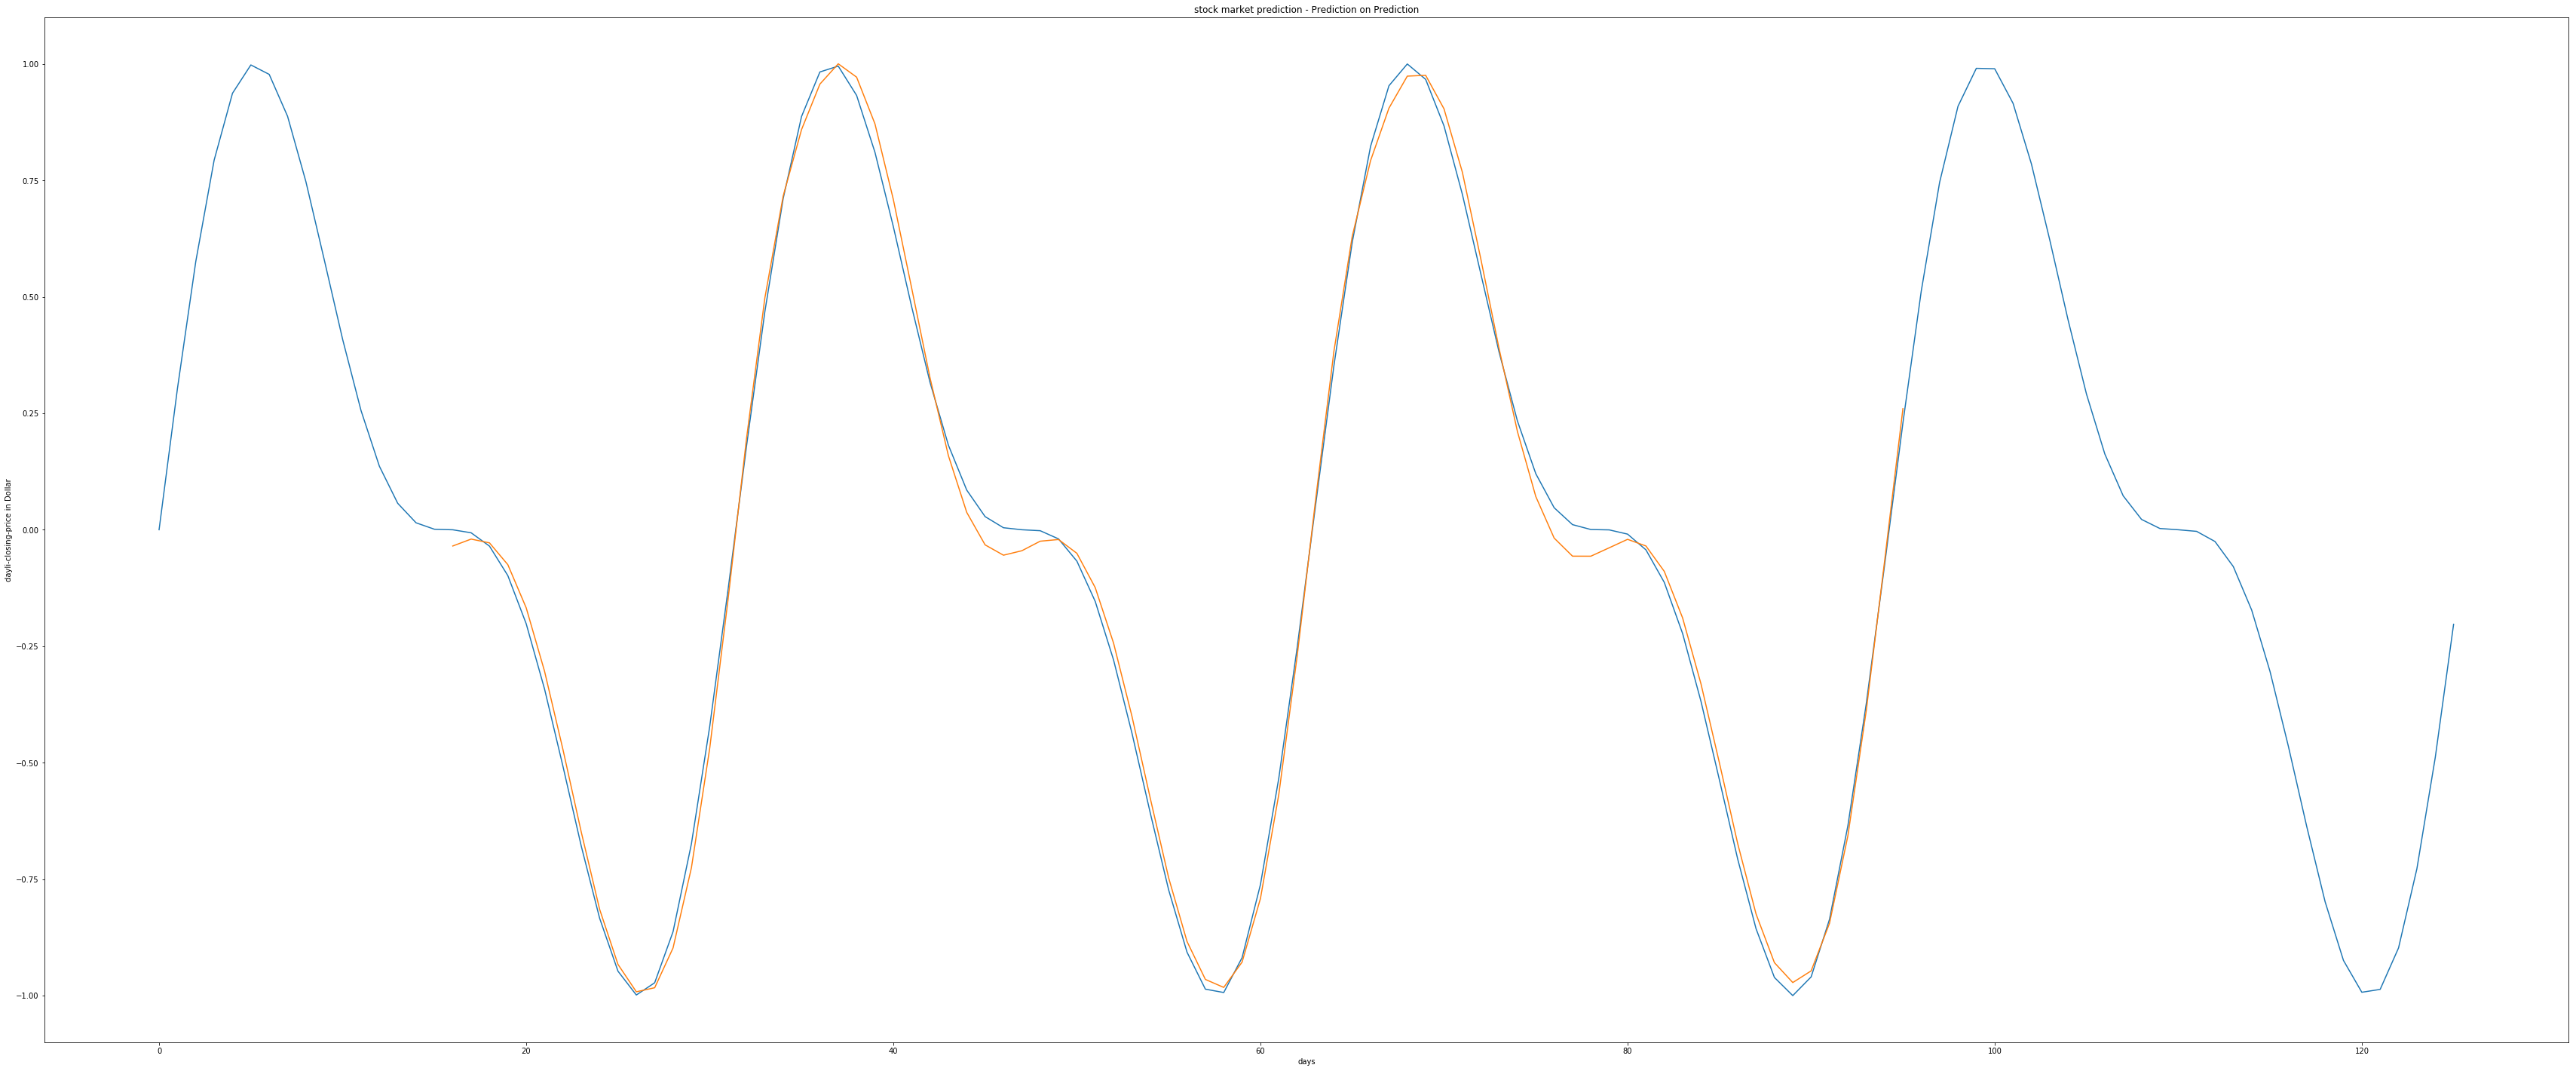

In [35]:
plot_dataframe_with_args([[x for x in range(len(scaled_dataset))], scaled_dataset], [[y for y in range(window_size,window_size+len(traind_scores))], traind_scores])